## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

from environment import TrafficModel, Car
from util.network import create_generalized_braess_network, create_cars, build_network
from util.analysis import draw_network

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm, trange
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

In [4]:
def change_value_of_money(cars, possible_values, *, seed=42):
    rng = np.random.default_rng(seed)

    for car in cars.values():
        car.value_of_money = rng.choice(possible_values)

In [18]:
def compute_regression(data):
    lrr = LinearRegression()
    est = lrr.fit(data.index.to_numpy().reshape(-1, 1), data.to_numpy())
    error = mean_squared_error(data.to_numpy(), lrr.predict(data.index.to_numpy().reshape(-1, 1)))

    return est.coef_[0], est.intercept_, error

## Sanity check: Show generalized Braess graph

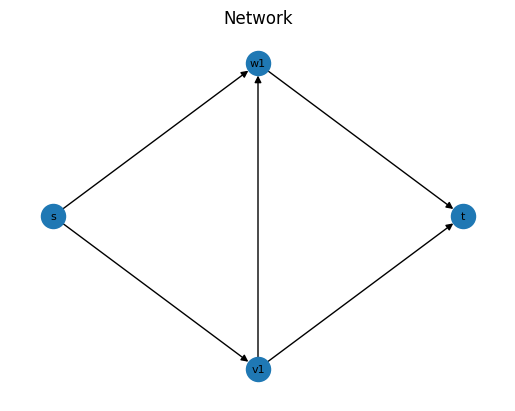

In [5]:
draw_network(create_generalized_braess_network(1))

## Find optimal capacity

100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


Best improvement found with capacity: restricted
True    30
dtype: int64


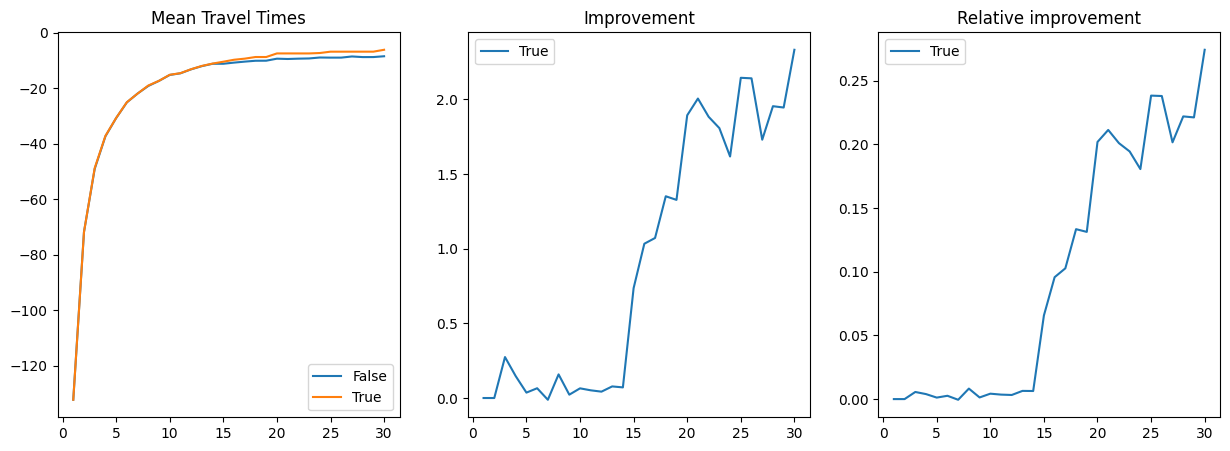

In [33]:
k = 1
number_of_steps = 1_000
car_counts = {('s', 't'): 30}
capacities = range(1, 31)

mean_travel_times = []
for capacity in tqdm(capacities):
    for restricted in [False, True]:
        network = create_generalized_braess_network(k, capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        
        if restricted:
            # Close all edges of type A
            for i in range(1, k + 1):
                model.set_edge_restriction((f'v{i}', f'w{i}'), False)

        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times.append({'capacity': capacity, 'restricted': restricted, 'travel_time': (-car_stats["travel_time"]).mean()})

mean_travel_times = pd.DataFrame(mean_travel_times).set_index(["capacity", "restricted"]).unstack(level=1)['travel_time']

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(capacities, mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([False], axis=1).sub(mean_travel_times[False], axis=0)
ax2.plot(capacities, improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[False].abs(), axis=0)
ax3.plot(capacities, relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

print(f'Best improvement found with capacity: {improvement.idxmax()}')

## Analyze improvement for varying `k`

100%|██████████| 19/19 [03:55<00:00, 12.41s/it]


Best improvement found with k: 9


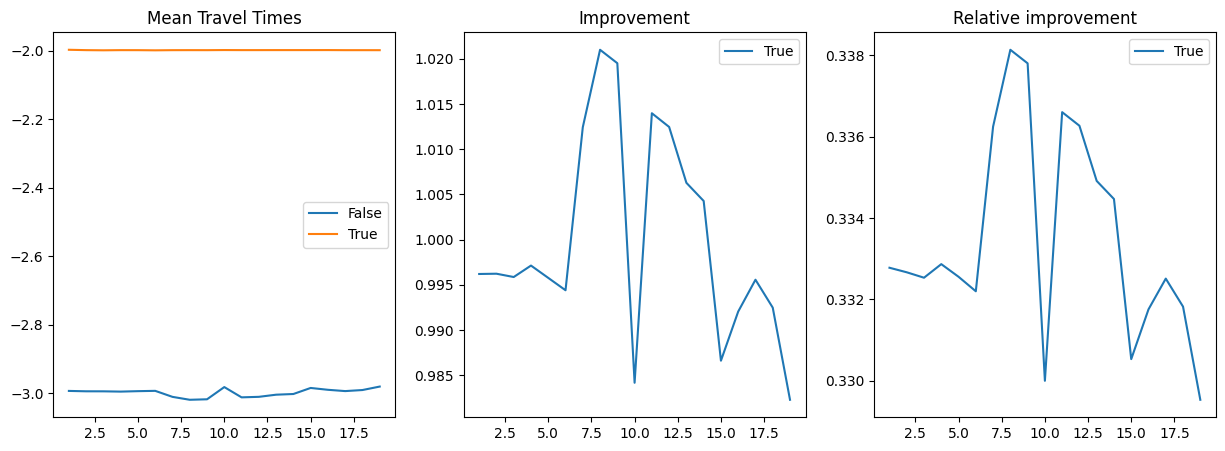

In [8]:
ks = range(1, 20)
number_of_steps = 1_000
car_counts = {('s', 't'): 30}
capacity = 30

mean_travel_times = []
for k in tqdm(ks):
    for restricted in [False, True]:
        network = create_generalized_braess_network(k, capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        
        if restricted:
            # Close all edges of type A
            for i in range(1, k + 1):
                model.set_edge_restriction((f'v{i}', f'w{i}'), False)

        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times.append({'k': k, 'restricted': restricted, 'travel_time': (-car_stats["travel_time"]).mean()})

mean_travel_times = pd.DataFrame(mean_travel_times).set_index(["k", "restricted"]).unstack(level=1)['travel_time']

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([False], axis=1).sub(mean_travel_times[False], axis=0)
ax2.plot(improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[False].abs(), axis=0)
ax3.plot(relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

print(f'Best improvement found with k: {np.argmax(improvement.max(axis=1)) + 2}')

## Analyze improvement for varying number of closed edges

100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Text(0.5, 1.0, 'Relative improvement')

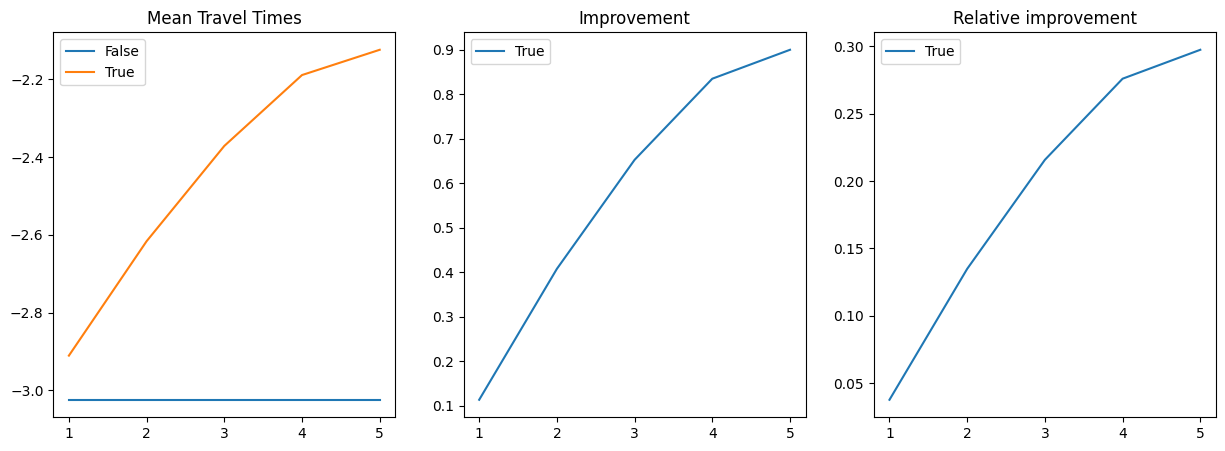

In [232]:
k = 5
es = range(1, k + 1)
number_of_steps = 1_000
car_counts = {('s', 't'): 30}
capacity = 15

mean_travel_times = []
for e in tqdm(es):
    for restricted in [False, True]:
        network = create_generalized_braess_network(k, capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        
        if restricted:
            # Close all edges of type A
            for i in range(1, e + 1):
                model.set_edge_restriction((f'v{i}', f'w{i}'), False)

        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times.append({'e': e, 'restricted': restricted, 'travel_time': (-car_stats["travel_time"]).mean()})

mean_travel_times = pd.DataFrame(mean_travel_times).set_index(["e", "restricted"]).unstack(level=1)['travel_time']

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([False], axis=1).sub(mean_travel_times[False], axis=0)
ax2.plot(improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[False].abs(), axis=0)
ax3.plot(relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

# print(f'Best improvement found with k: {np.argmax(improvement.max(axis=1)) + 2}')

## Individual scenarios

### Unrestricted

In [173]:
k = 1
number_of_steps = 1000
car_counts = {('s', 't'): 30}

network = create_generalized_braess_graph(k, capacity=13)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

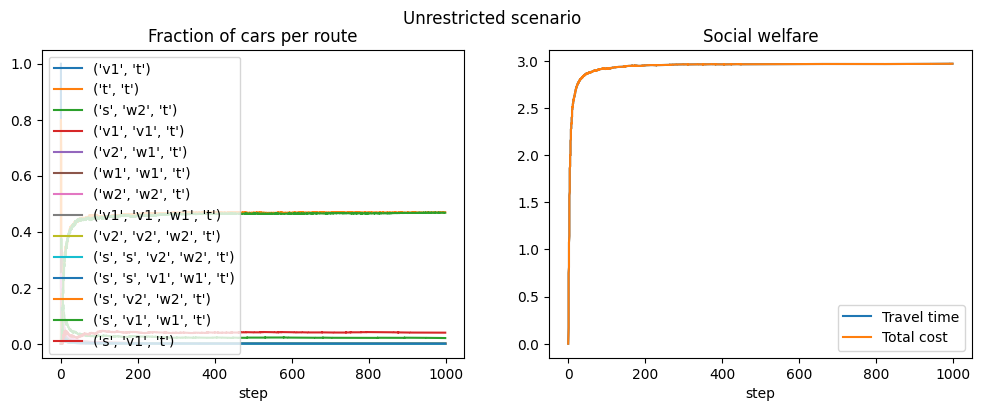

In [174]:
plot_results(car_stats, title='Unrestricted scenario')

### Restricted

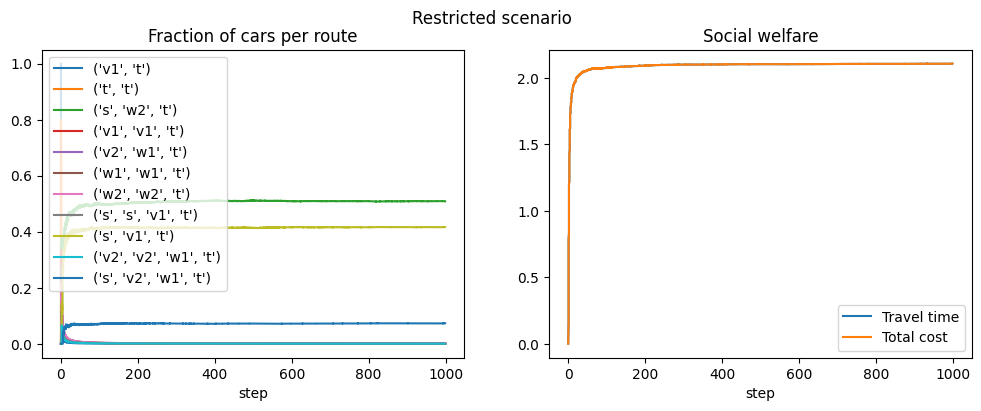

In [175]:
k = 2
number_of_steps = 1000
car_counts = {('s', 't'): 30}

network = create_generalized_braess_graph(k, capacity=13)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

# Close all edges of type A
for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

plot_results(car_stats, title='Restricted scenario')

## Comparison of unrestricted and restricted

In [159]:
k = 2
number_of_steps = 2_000
car_counts = {('s', 't'): 30}
capacity = 13

In [160]:
# Unrestricted
network = create_generalized_braess_graph(k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_generalized_braess_graph(k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

# Close all edges of type A
for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

Unrestricted mean travel time: -2.968794888305513
Restricted mean travel time: -2.107201855822291


Text(0.5, 0.98, 'Travel time')

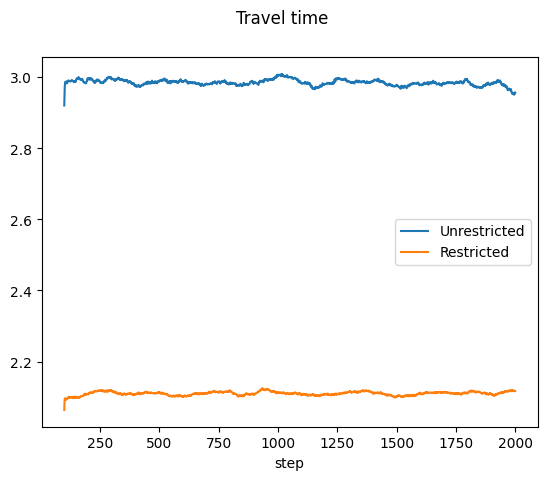

In [167]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted.groupby('step')['travel_time'].mean(), 
    'Restricted': car_stats_restricted.groupby('step')['travel_time'].mean()}).rolling(100).mean().plot(ax=ax, xlabel='step')

fig.suptitle("Travel time")

## Tolling

In [18]:
k = 1
number_of_steps = 1_000
car_counts = {('s', 't'): 30}
capacity = 13
values_of_money = [0.0, 0.5, 1.0, 2.0, 5.0]

In [19]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

In [20]:
network = create_generalized_braess_network(k, capacity=capacity)
cars = create_cars(network, car_counts=car_counts)

# Assign different value_of_money to cars
change_value_of_money(cars, values_of_money)

# Run tolling
model = TrafficModel(network, cars, tolls=True, beta=1, R=0.5)
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats["total_cost"]).mean()}')

Mean travel time with tolling: -2.4203121209670897
Mean total cost with tolling: -3.344759881334668


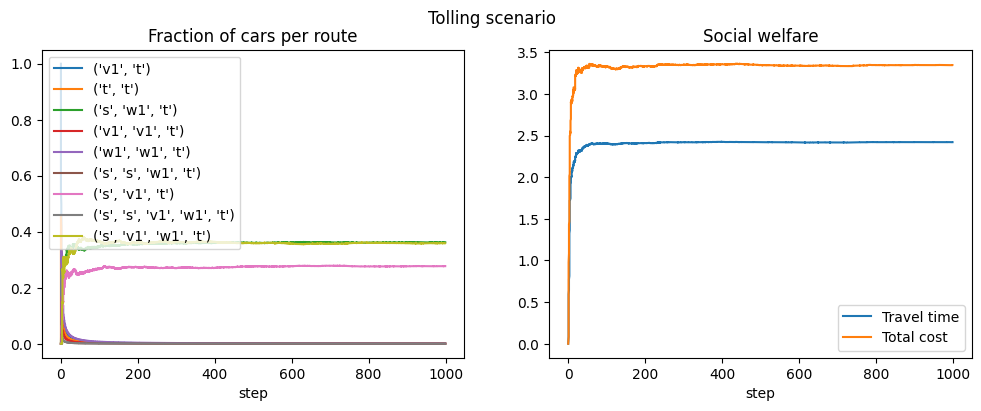

In [21]:
plot_results(car_stats, title='Tolling scenario')

In [22]:
car_stats.groupby('value_of_money')['travel_time'].mean()

value_of_money
0.0    2.934706
0.5    2.635403
1.0    2.438111
2.0    2.294659
5.0    2.156074
Name: travel_time, dtype: float64

## Comparison of all three scenarios

In [28]:
k = 1
number_of_steps = 1_000
car_counts = {('s', 't'): 30}
capacity = 13
values_of_money = [0.0, 0.5, 1.0, 2.0, 5.0]

# Unrestricted
network = create_generalized_braess_network(k, capacity=capacity)
cars = create_cars(network, car_counts=car_counts)
change_value_of_money(cars, values_of_money)
model = TrafficModel(network, cars)
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_generalized_braess_network(k, capacity=capacity)
cars = create_cars(network, car_counts=car_counts)
change_value_of_money(cars, values_of_money)
model = TrafficModel(network, cars)

# Close all edges of type A
for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

# Tolling
network = create_generalized_braess_network(k, capacity=capacity)
cars = create_cars(network, car_counts=car_counts)
change_value_of_money(cars, values_of_money)
model = TrafficModel(network, cars, tolls=True, beta=1, R=0.5)
step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Unrestricted mean travel time: -2.9410493220672036
Restricted mean travel time: -1.9975326753801013
Mean travel time with tolling: -2.4203121209670897
Mean total cost with tolling: -3.344759881334668


Text(0.5, 0.98, "Braess' Paradox")

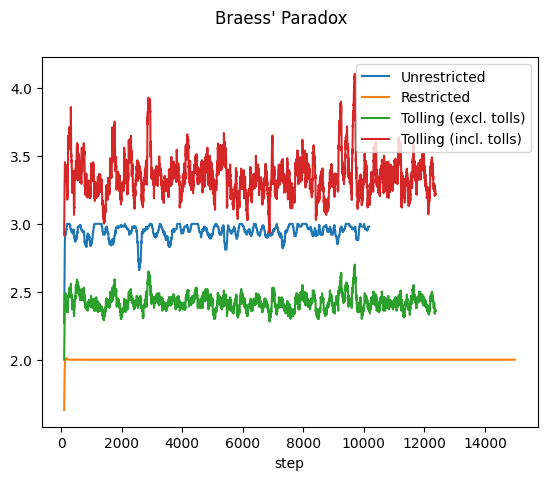

In [32]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted['travel_time'], 
    'Restricted': car_stats_restricted['travel_time'], 
    'Tolling (excl. tolls)': car_stats_tolling['travel_time'], 
    'Tolling (incl. tolls)': car_stats_tolling['total_cost']}).rolling(100).mean().plot(ax=ax, xlabel='step')

fig.suptitle("Braess' Paradox")

<Axes: title={'center': 'Toll per edge'}>

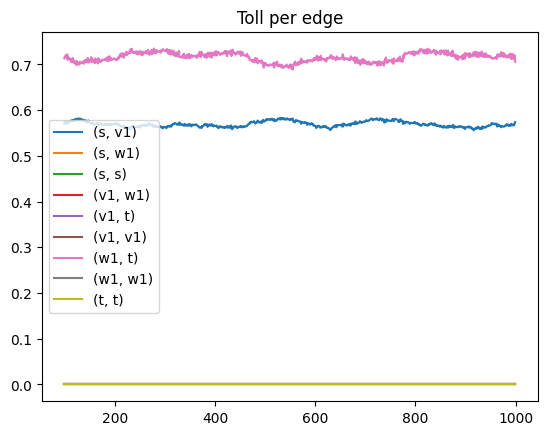

In [30]:
step_stats_tolling['toll'].rolling(100).mean().plot(title='Toll per edge')

## Find optimal `capacity` for each `k`

100%|██████████| 5/5 [03:23<00:00, 40.65s/it]


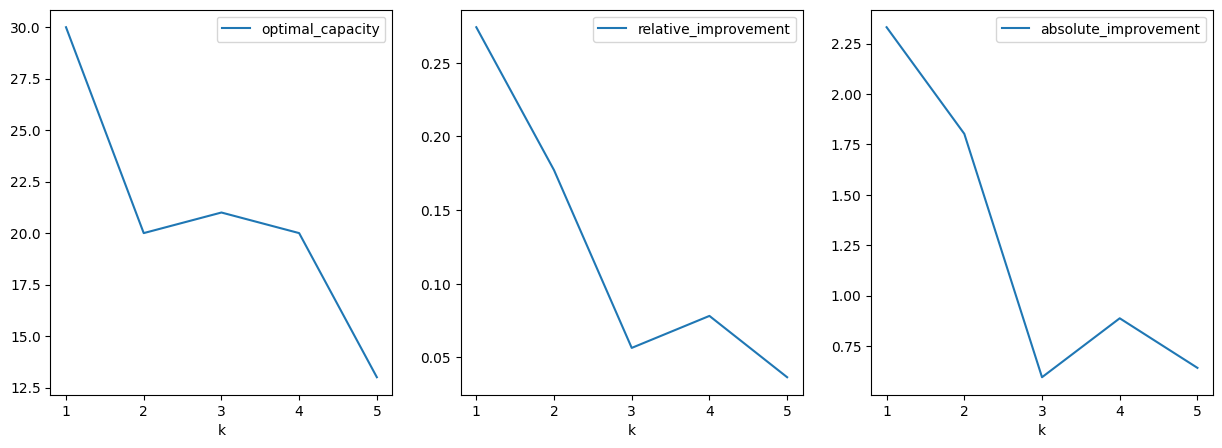

In [34]:
number_of_steps = 1_000
car_counts = {('s', 't'): 30}

ks = range(1, 6)
results = []
for k in tqdm(ks):
    capacities = range(1, 31)
    mean_travel_times = []
    for capacity in tqdm(capacities):
        for restricted in [False, True]:
            network = create_generalized_braess_network(k, capacity=capacity)
            model = TrafficModel(network, create_cars(network, car_counts=car_counts))
            
            if restricted:
                # Close all edges of type A
                for i in range(1, k + 1):
                    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

            step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

            mean_travel_times.append({'capacity': capacity, 'restricted': restricted, 'travel_time': (-car_stats["travel_time"]).mean()})

    mean_travel_times = pd.DataFrame(mean_travel_times).set_index(["capacity", "restricted"]).unstack(level=1)['travel_time']
    improvement = mean_travel_times[True] - mean_travel_times[False]
    relative_improvement = improvement.div(mean_travel_times[False].abs(), axis=0)

    results.append({'k': k, 'optimal_capacity': relative_improvement.idxmax(), 'absolute_improvement': improvement.max(), 'relative_improvement': relative_improvement.max()})

results = pd.DataFrame(results).set_index('k')

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

results['optimal_capacity'].plot(ax=ax1)
ax1.legend()

results['relative_improvement'].plot(ax=ax2)
ax2.legend()

results['absolute_improvement'].plot(ax=ax3)
ax3.legend()

## Use different values for `value_of_money` and check for fairness

In [21]:
k = 1
degree = 1
capacity = 17
number_of_steps = 3_000
car_counts = {('s', 't'): 30}
values_of_money = [0, 1, 2, 5]
seed = 42

In [22]:
network = create_generalized_braess_network(k, capacity=capacity, degree=degree)
cars = create_cars(network, car_counts=car_counts, seed=seed)

# Assign different value_of_money to cars
change_value_of_money(cars, values_of_money, seed=seed)

# Run unrestricted
model = TrafficModel(network, cars, seed=seed)
step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {car_stats_unrestricted["travel_time"].mean()}')

Unrestricted mean travel time: 2.9978665244349623


In [23]:
network = create_generalized_braess_network(k, capacity=capacity, degree=degree)
cars = create_cars(network, car_counts=car_counts, seed=seed)

# Assign different value_of_money to cars
change_value_of_money(cars, values_of_money, seed=seed)

# Run restricted
model = TrafficModel(network, cars, seed=seed)

for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {car_stats_restricted["travel_time"].mean()}')

Restricted mean travel time: 1.9991332948131029


In [24]:
network = create_generalized_braess_network(k, capacity=capacity, degree=degree)
cars = create_cars(network, car_counts=car_counts, seed=seed)

# Assign different value_of_money to cars
change_value_of_money(cars, values_of_money, seed=seed)

# Run tolling
model = TrafficModel(network, cars, tolls=True, beta=1, R=0.5, seed=seed)
step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Mean travel time with tolling: -2.3787814681616246
Mean total cost with tolling: -3.4296424200325126


In [25]:
cutoff = 5_00
rolling = 2_00

In [26]:
u = car_stats_unrestricted[car_stats_unrestricted['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()
r = car_stats_restricted[car_stats_restricted['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()
t = car_stats_tolling[car_stats_tolling['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()

travel_times = pd.concat([u, r, t], keys=['unrestricted', 'restricted', 'tolling'], axis=1)

slope=0.0, intercept=3.0
slope=0.0, intercept=2.0
slope=-0.15399131064557012, intercept=2.7800084999970576


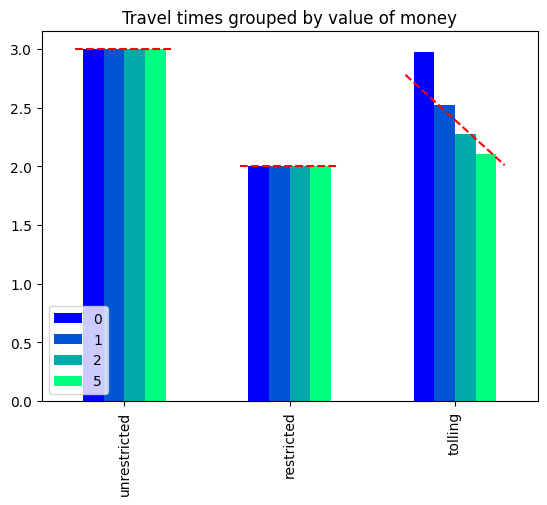

In [27]:
ax = travel_times.transpose().plot(kind='bar', cmap=mpl.colormaps['winter'])
ax.legend(loc='lower left')
ax.set_title('Travel times grouped by value of money')

for offset, data in enumerate([u, r, t]):
    slope, intercept, _ = compute_regression(data)
    ax.plot([offset - 0.3, offset + 0.3], [intercept, intercept + 5*slope], 'r--')
    print(f'{slope=}, {intercept=}')

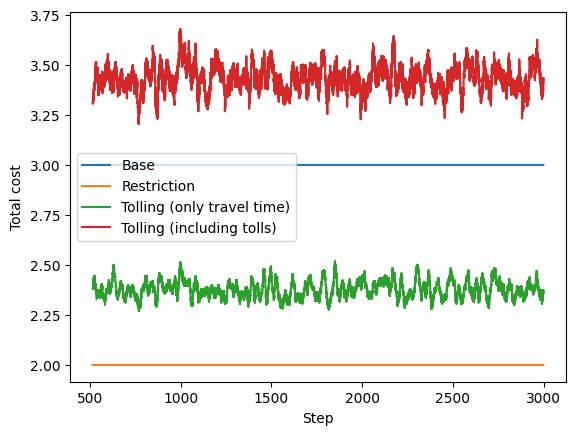

In [29]:
fig, ax = plt.subplots(1, 1)

ax.plot(car_stats_unrestricted[car_stats_unrestricted['step'] >= cutoff].set_index('step')['travel_time'].rolling(rolling).mean(), label='Base')
ax.plot(car_stats_restricted[car_stats_restricted['step'] >= cutoff].set_index('step')['travel_time'].rolling(rolling).mean(), label='Restriction')
ax.plot(car_stats_tolling[car_stats_tolling['step'] >= cutoff].set_index('step')['travel_time'].rolling(rolling).mean(), label='Tolling (only travel time)')
ax.plot(car_stats_tolling[car_stats_tolling['step'] >= cutoff].set_index('step')['total_cost'].rolling(rolling).mean(), label='Tolling (including tolls)')

ax.set_xlabel('Step')
ax.set_ylabel('Total cost')
ax.legend()